In [1]:
import duckdb
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

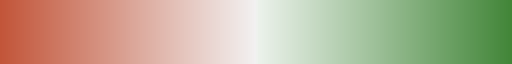

In [3]:
sns.set_theme()
sns.set_style('ticks', {"axes.grid": True})
sns.set_context('talk')
hm_w = 7.5
hm_h = 2.75
set_title = False
my_cmap = sns.diverging_palette(20, 125, as_cmap=True)
my_cmap

In [4]:
my_palette = sns.diverging_palette(20, 125)
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

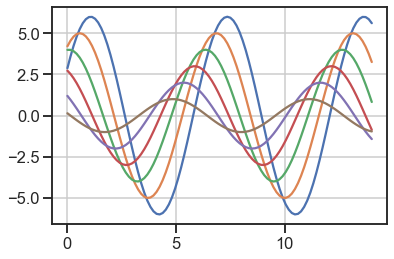

In [5]:
x = np.linspace(0, 14, 100)
for i in range(1, 7):
    plt.plot(x, np.sin(x + i * .5) * (7 - i) * 1)

In [6]:
con = duckdb.connect()
grouping_cols = ['count', 'columns', 'col_width', 'category']

# Functions

In [7]:
def load_csv(con, csv_path, median_cols):
    q = "select "
    q += ", ".join(grouping_cols)
    q += ", " + ", ".join([f"median({c}) as {c}" for c in median_cols])
    q += f" from read_csv_auto('{csv_path}') "
    q += "group by " + ", ".join(grouping_cols)
    q += " order by " + ", ".join(grouping_cols)
    con.execute(q)
    return con.fetchdf()

In [8]:
def compute_relative_runtime(con, df, cat1, cat2, col):
    q = "select\n\tcast(log2(c1.count) as int) as row_count,"
    q += f"\n\tc1.columns,\n\tc1.col_width,\n\tc1.{col} as {cat1}_{col},\n\tc2.{col} as {cat2}_{col},"
    q += f"\n\tround(c1.{col} / c2.{col}, 1) as relative_runtime"
    q += f"\nfrom\n\tdf c1,\n\tdf c2"
    q += f"\nwhere\n\tc1.category = '{cat1}'\nand\tc2.category = '{cat2}'\nand\t"
    q += "\nand\t".join([f"c1.{c} = c2.{c}" for c in grouping_cols[:-1]])
    q += "\norder by\n\trow_count,\n\t"
    q += ",\n\t".join([f"c1.{c}" for c in grouping_cols[1:-1]])
    con.execute(q)
    return con.fetchdf()

In [91]:
def get_color_norm(dfs, col):
    vmin = 1e99
    vmax = 0
    for df in dfs:
        vmin = min(vmin, min(df[col]))
        vmax = max(vmax, max(df[col]))
    if vmin < 1:
        vmin = 1 / vmin
    else:
        vmin = 1
    factor = min(max(1 / vmin, vmax), 4)
    vmin = 1 / factor
    vmax = factor
    return colors.TwoSlopeNorm(1, vmin=vmin, vmax=vmax)

In [10]:
def create_heatmap(df, columns, title, fname, w=hm_w, h=hm_h):
    color_norm = get_color_norm([df], columns[2])
    fig, ax = plt.subplots(figsize=(w, h))
    g = sns.heatmap(df.pivot(columns[0], columns[1], columns[2]), linewidths=0, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True, cbar=False, norm=color_norm)
    g.invert_yaxis()
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    if set_title:
        plt.title(f'Relative runtime of {title}')
    ax.set_xlabel('rows')
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

In [11]:
def multi_heatmap(dfs, titles, columns, fname, w=hm_w, h=hm_h, normalize_colors=False):
    fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(w *len(dfs), h), sharey=True)
    color_norm = get_color_norm(dfs, columns[2]) if normalize_colors else None
    
    for i in range(len(dfs)):
        ax = axes[i]
        sns.heatmap(dfs[i].pivot(columns[0], columns[1], columns[2]), linewidths=0, cbar=False, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True,
                    norm=color_norm)
        ax.invert_yaxis()
        for _, spine in ax.spines.items():
            spine.set_visible(True)
        labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
        ax.set_xlabel('rows')
        ax.set_title(titles[i])
        if i > 0:
            ax.set_ylabel('')
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='y', which='major', length=0)
    plt.subplots_adjust(wspace=0.05)
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

# Reordering

In [12]:
reorder_df = load_csv(con, 'results/reorder.csv', ['total', 'reorder', 'scatter', 'gather'])
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,1.136658e+10
1,row,1.243154e+10


In [13]:
reorder_total_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_total_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.496429,0.4


In [14]:
# create_heatmap(reorder_total_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'payload reordering rows vs. columns (incl. scatter + gather)',
#                'reorder_incl_sg')

In [15]:
reorder_only_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'reorder')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_only_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.6,1.4


In [16]:
# create_heatmap(reorder_only_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'payload reordering rows vs. columns (excl. scatter + gather)',
#                'reorder_excl_sg')

0.25 4.0


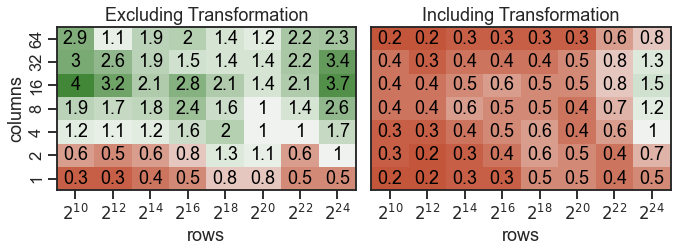

In [17]:
multi_heatmap([reorder_only_df, reorder_total_df], ['Excluding Transformation', 'Including Transformation'],
              ['columns', 'row_count', 'relative_runtime'],
              'reorder', w=5.5, h=3, normalize_colors=True)

In [18]:
# con.execute("""
#     select
#         cast(log2(count) as int) as row_count,
#         columns,
#         col_width,
#         reorder as "row reorder",
#         round(cast(scatter + gather as double) / total, 1) as sg
#     from
#         reorder_df
#     where
#         category = 'row'
#     order by
#         row_count asc,
#         columns asc
# """)
# reorder_percentage_df = con.fetchdf()
# con.execute('select avg(sg), median(sg) from reorder_percentage_df')
# con.fetchdf()

In [19]:
# create_heatmap(reorder_percentage_df,
#                ['columns', 'row_count', 'sg'],
#                'scatter + gather as percentage of reorder runtime',
#                'reorder_sg_percentage')

# Comparator

In [20]:
comparator_df = load_csv(con, 'results/comparator.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,586246166.0
1,col_branchless,899911754.0
2,col_ss,263136044.0
3,row_all,336936166.0
4,row_all_branchless,465570292.0
5,row_iter,234691838.0
6,row_norm,301614379.0


In [21]:
con.execute("""
select 
       min(1 - sort / total) as min_sg,
       max(1 - sort / total) as max_sg,
       avg(1 - sort / total) as avg_sg,
       median(1 - sort / total) as median_sg
from comparator_df
where category != 'col'
  and category != 'col_branchless'
  and category != 'col_ss'
-- order by category
""")
con.fetchdf()
# print(con.fetchdf().to_latex(index=False, float_format='%.2f'))

,min_sg,max_sg,avg_sg,median_sg
0,0.031012,0.191595,0.076587,0.071172


In [22]:
comparator_col_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'col_ss', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.655556,1.6


In [23]:
# create_heatmap(comparator_col_iter_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'columnar_iterative vs. columnar_all (pdqsort)',
#                'comparator_col_iter')

In [24]:
comparator_col_branchless_df = compute_relative_runtime(con, comparator_df, 'col', 'col_branchless', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.775,0.8


In [25]:
# create_heatmap(comparator_col_branchless_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'columnar_branchless vs. columnar_all (pdqsort)',
#                'comparator_col_branchless')

In [89]:
comparator_col_baseline_df = compute_relative_runtime(con, comparator_df, 'col', 'col', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_baseline_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.0,1.0


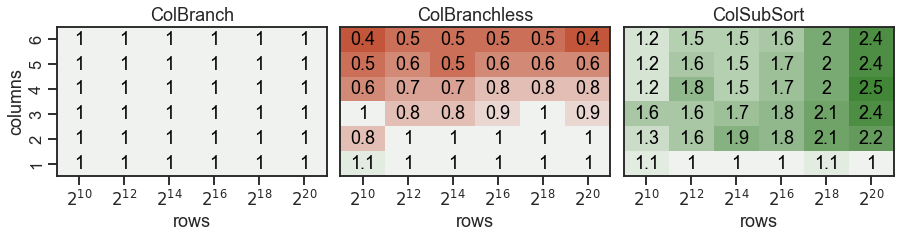

In [101]:
multi_heatmap([comparator_col_baseline_df, comparator_col_branchless_df, comparator_col_iter_df],
              ['ColBranch', 'ColBranchless', 'ColSubSort'],
              ['columns', 'row_count', 'relative_runtime'],
              'column_comparators', w=5, h=2.75, normalize_colors=True)

In [93]:
comparator_row_all_df = compute_relative_runtime(con, comparator_df, 'col', 'row_all', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_all_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.555556,1.5


In [28]:
# create_heatmap(comparator_row_all_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'row_all vs. columnar_iterative (pdqsort)',
#                'comparator_row_all')

In [94]:
comparator_row_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'row_iter', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.955556,1.8


In [30]:
# create_heatmap(comparator_row_iter_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'row_iter vs. columnar_iterative (pdqsort)',
#                'comparator_row_iter')

In [95]:
comparator_row_branchless_df = compute_relative_runtime(con, comparator_df, 'col', 'row_all_branchless', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.263889,1.25


In [32]:
# create_heatmap(comparator_row_branchless_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'row_all_branchless vs. row_all (pdqsort)',
#                'comparator_row_branchless')

In [96]:
comparator_norm_key_df = compute_relative_runtime(con, comparator_df, 'col', 'row_norm', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_norm_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.725,1.8


In [34]:
# create_heatmap(comparator_norm_key_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'normalized_key vs. columnar_iterative (pdqsort)',
#                'comparator_norm_key')

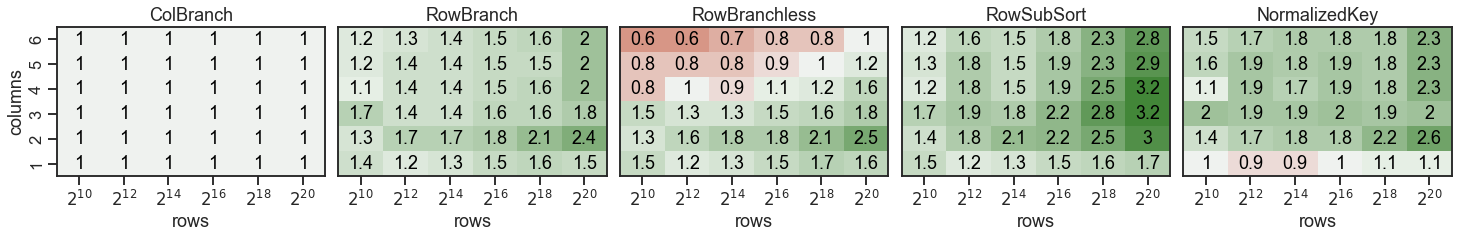

In [106]:
multi_heatmap([comparator_col_baseline_df, comparator_row_all_df, comparator_row_branchless_df, comparator_row_iter_df, comparator_norm_key_df],
              ['ColBranch', 'RowBranch', 'RowBranchless', 'RowSubSort', 'NormalizedKey'],
              ['columns', 'row_count', 'relative_runtime'],
              'row_comparators', w=5, h=2.75, normalize_colors=True)

# Sort

In [36]:
sort_skewed_df = load_csv(con, 'results/sort_skewed.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_skewed_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_static,4.960623e+09
1,radix,4.378993e+09


In [37]:
sort_skewed_rel_df = compute_relative_runtime(con, sort_skewed_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_skewed_rel_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.922917,0.9


In [38]:
# create_heatmap(sort_skewed_rel_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'pdq_static vs. radix',
#                'sort_skewed')

In [39]:
sort_random_df = load_csv(con, 'results/sort_random.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_random_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_static,4.572771e+09
1,radix,3.396126e+09


In [40]:
sort_random_rel_df = compute_relative_runtime(con, sort_random_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_random_rel_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.447917,1.2


In [41]:
# create_heatmap(sort_random_rel_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'pdq_static vs. radix',
#                'sort_random')

0.25 4.0


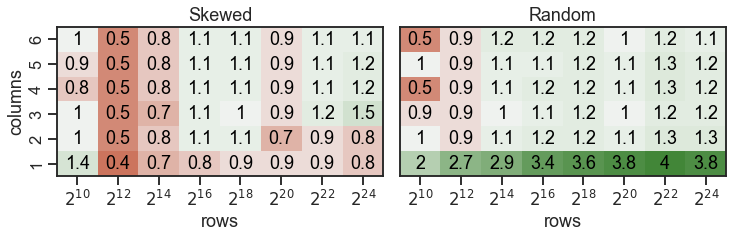

In [42]:
multi_heatmap([sort_skewed_rel_df, sort_random_rel_df],
              ['Skewed', 'Random'],
              ['columns', 'row_count', 'relative_runtime'],
              'sort', w=6, h=2.75, normalize_colors=True)

# Merge Key

In [43]:
merge_key_df = load_csv(con, 'results/merge_key.csv', ['total'])
con.execute("select category, sum(total) from merge_key_df group by category")
con.fetchdf()

,category,sum(total)
0,col_branch,86809538.0
1,col_branchless,167732163.0
2,row_all,31638831.0
3,row_all_branchless,62815873.0
4,row_norm,39938377.0


In [44]:
merge_key_col_branchless_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'col_branchless', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_col_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.536111,0.5


In [45]:
merge_key_row_branch_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'row_all', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_row_branch_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.561111,2.7


In [46]:
merge_key_row_branchless_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'row_all_branchless', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_row_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.283333,1.3


In [47]:
merge_key_norm_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'row_norm', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_norm_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.494444,2.75


In [99]:
merge_key_baseline_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'col_branch', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_baseline_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.0,1.0


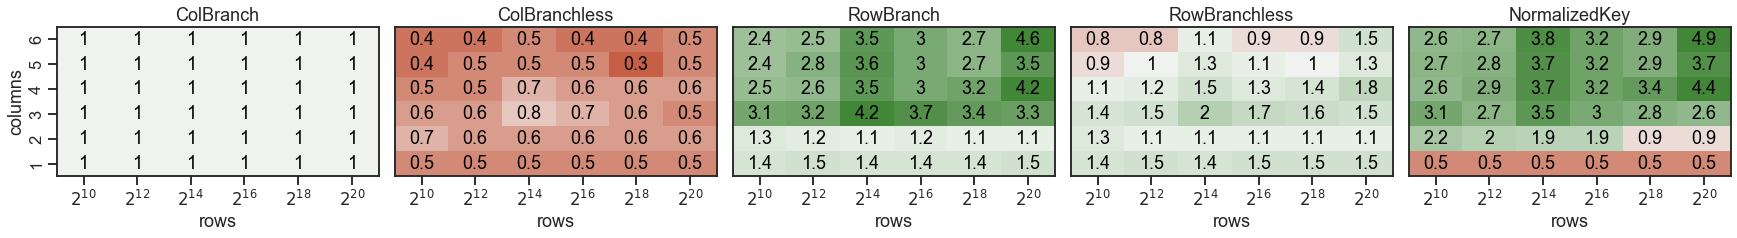

In [100]:
multi_heatmap([merge_key_baseline_df, merge_key_col_branchless_df, merge_key_row_branch_df, merge_key_row_branchless_df, merge_key_norm_df],
              ['ColBranch', 'ColBranchless', 'RowBranch', 'RowBranchless', 'NormalizedKey'],
              ['columns', 'row_count', 'relative_runtime'],
              'merge_key', w=6, h=2.75, normalize_colors=True)

# Merge Payload

In [49]:
merge_payload_df = load_csv(con, 'results/merge_payload.csv', ['total'])
con.execute("select category, sum(total) from merge_payload_df group by category")
con.fetchdf()

,category,sum(total)
0,col,128937206.0
1,row,60559497.0


In [50]:
merge_payload_runtime_df = compute_relative_runtime(con, merge_payload_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_payload_runtime_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.291667,2.1


0.25 4


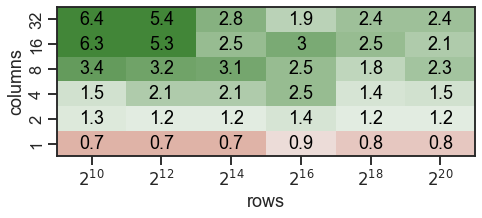

In [51]:
create_heatmap(merge_payload_runtime_df,
               ['columns', 'row_count', 'relative_runtime'],
               'merging rows vs. merging columns',
               'merge_payload')

# Static vs. Dynamic

In [52]:
mem_colors = [my_palette[0], my_palette[5]]

In [53]:
con.execute("""
select 'memcpy' as function, * from read_csv_auto('results/memcpy.csv')
union all
select 'memcmp' as function, * from read_csv_auto('results/memcmp.csv')
""")
mem_df = con.fetchdf()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


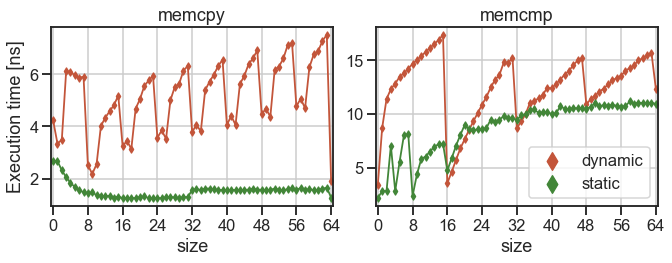

In [54]:
with plt.rc_context({'lines.linewidth': 1}):
    plot = sns.catplot(data=mem_df, kind='point', x='num_bytes', y='time', col='function', hue='type', col_wrap=2,
                       sharex=True, sharey=False, markers=['d', 'd'], height=4, palette=mem_colors,
                       facet_kws=dict(despine=False))

plot.axes[0].set(ylabel='Execution time [ns]', xlabel='size', title='memcpy')
plot.axes[1].set(ylabel=None, xlabel='size', title='memcmp')

for ax in plot.axes:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([25])

plot._legend.set_visible(False)
with plt.rc_context({'legend.markerscale': 2.5}):
    lgnd = plot.axes[1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.savefig('figures/mem.eps', bbox_inches='tight')

In [55]:
con.execute("""
select max(d.time / s.time) as speedup, d.function, d.num_bytes
from mem_df d, mem_df s
where d.type = 'dynamic'
and s.type = 'static'
and d.function = s.function
and d.num_bytes = s.num_bytes
group by d.function, d.num_bytes
order by speedup desc
""")
speedup = con.fetchdf()
speedup.head(20)

,speedup,function,num_bytes
0,6.130228,memcmp,8
1,4.908285,memcpy,31
2,4.760761,memcpy,30
3,4.760472,memcpy,23
4,4.608924,memcpy,22
5,4.543703,memcpy,63
6,4.530156,memcpy,62
7,4.508486,memcmp,4
8,4.500775,memcpy,29
9,4.490326,memcpy,54


# Trace

In [56]:
def process_trace_csv(con, csv_path, counter, ns_per_grp):
    time_group_size = 20000000
    if counter is 'cm':
        counter = 'L1D_CACHE_MISS_LD + L1D_CACHE_MISS_ST'
    elif counter is 'bm':
        counter = 'BRANCH_COND_MISPRED_NONSPEC'
    else:
        '4' + 2
    con.execute(f"""
    with trace_csv1 as (select * from read_csv_auto('{csv_path}', sample_size=30000)),
    trace_csv2 as (
        select
            category,
            cast(time / {ns_per_grp} as bigint) as time,
            {counter} as counter
        from trace_csv1
    ),
    trace_csv3 as (
        select category, time, sum(counter) counter
        from trace_csv2
        group by category, time
    ),
    trace_csv4 as (
        select category, time, counter,
               cast(lag(time, 1) over (partition by category order by time) as int) as lg1
        from trace_csv3
    ),
    bounds as (
        select * from trace_csv4
        where time - 1 != lg1
    ),
    filtered as (
        select *
        from trace_csv4 t
        where
            time >= (select min(time) from bounds b where t.category = b.category)
        and time < (select max(time) from bounds b where t.category = b.category)
    ),
    trace as (
        select
            category,
            (time - (select min(time) from filtered fs where f.category = fs.category group by category)) * {ns_per_grp} as time,
            counter
        from filtered f
    )
    select category,
    time,
    sum(counter) over (partition by category order by time rows between unbounded preceding and current row) counter
    from trace
    """)
    r1 = con.fetchdf()
    
    con.execute(f"""
    with continuous as (
        select *, lag(time, 1) over (partition by category order by time) as lg1
        from r1
    )
    select category, time, counter
    from continuous
    where time = lg1 + {ns_per_grp}
       or lg1 is null
    order by category, time
    """)
    r2 = con.fetchdf()
    
    print('rows:', len(r2))
    con.execute("select max(time) from r2")
    print('max time:', con.fetchall()[0][0])
    return r2

In [57]:
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

In [58]:
my_palette2 = sns.diverging_palette(410, 300)
my_palette2

[(0.5960462953792985, 0.4367356573149547, 0.22363678291062888),
 (0.7382569423367272, 0.6397325997771124, 0.5096555314022133),
 (0.8818563651433494, 0.844711934255502, 0.7984674317345357),
 (0.9026656191584234, 0.8129874999063101, 0.916812673260778),
 (0.8069596067933752, 0.543048985174488, 0.847409814159564),
 (0.7121791844898844, 0.2757210943762422, 0.7786781625931779)]

In [59]:
trace_palette_map = {
    'Branch': my_palette[0],
    'Branchless': my_palette[5],
    'SubSort': my_palette2[0],
    'NormalizedKey': my_palette2[5]
}

In [60]:
def plot_trace(df, counter, fig_name, categories=None, h=5, asp=1, the_ax=None, lg=False, yl=True, title=None):
    if not the_ax:
        plt.figure(figsize=(h*asp, h))
    if categories:
        if len(categories) == 2:
            palette = [my_palette[0], my_palette[5]]
            markers = ['d', 'd']
        else:
            markers = ['d' if 'Col' in cat else 's' for cat in categories]
            palette = [trace_palette_map.get(cat.replace('Col', '').replace('Row', ''), my_palette[0]) for cat in categories]
    else:
        markers = ['d']*20
        palette = sns.color_palette()
    with plt.rc_context({'lines.linewidth': 1}):
        ax = sns.pointplot(data=df, x='time', y='counter', hue='category',
                           markers=markers, height=h, aspect=asp, facet_kws=dict(despine=False),
                           palette=palette, ax=the_ax, legend=False)
        ax.legend([], [], frameon=False)
    
    if max(df['counter']) / 1e9 > 1:
        q = '× 1e9'
        y_divisor = 1e9
    elif max(df['counter']) / 1e6 > 1:
        q = '× 1e6'
        y_divisor = 1e6
    elif max(df['counter']) / 1e3 > 1:
        q = '× 1e3'
        y_divisor = 1e3

    if counter == 'cm':
        ylabel = f'Cache misses {q}'
    else:
        ylabel = f'Branch mispredictions {q}'
    
    if yl:
        ax.set(ylabel=ylabel, xlabel='Execution time [s]')
    else:
        ax.set(ylabel='', xlabel='Execution time [s]')
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.subplots_adjust(wspace=0)

    ax.set_title(title)
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f'{float(label) / 1e9}' for label in xlabels])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.tick_params(axis='y', which='major', length=0)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: float(x / y_divisor)))

    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([40])

    if lg:
        with plt.rc_context({'legend.markerscale': 2}):
            lgnd = ax.legend(fontsize='small')
        if categories:
            for new, old in zip(categories, lgnd.get_texts()):
                old.set_text(new)
    
    if not the_ax:
        plt.savefig(f'figures/{fig_name}.eps', bbox_inches='tight')

In [61]:
def multi_trace(dfs, fig_name, categories, counters, h=5, asp=1, lg=0, titles=[None, None]):
    shy = counters[0] == counters[1]
    plot, axes = plt.subplots(nrows=1, ncols=2, figsize=(2 * h * asp, h), sharey=shy)
    for i in range(2):
        legend_on = lg == i
        if i == 1 and counters[0] == counters[1]:
            yl = False
        else:
            yl = True
        plot_trace(dfs[i], counters[i], '', categories=categories, h=h, asp=asp, the_ax=axes[i],
                   lg=legend_on, yl=yl, title=titles[i])
    plt.tight_layout()
    plt.savefig(f'figures/{fig_name}.eps', bbox_inches='tight')
    plt.show()

## Reorder

In [62]:
agg_ns = 100000000
# cm_reorder_excl_df = process_trace_csv(con, 'results/trace_reorder_excl.csv', 'cm', agg_ns)
cm_reorder_incl_df = process_trace_csv(con, 'results/trace_reorder_incl.csv', 'cm', agg_ns)

rows: 53
max time: 2600000000


In [63]:
# plot_trace(cm_reorder_excl_df, 'cm', 'cm_reorder_excl', ['Columns', 'Rows'], h=5, asp=1.5, lg=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


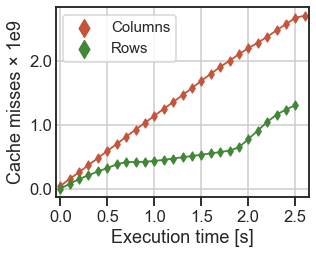

In [64]:
plot_trace(cm_reorder_incl_df, 'cm', 'trace_reorder', ['Columns', 'Rows'], h=3.5, asp=1.3, lg=True)

In [65]:
# con.execute("select * from cm_reorder_incl_df union all select 'row excl', time, counter from cm_reorder_excl_df where category = 'row'")
# cm_reorder_df = con.fetchdf()

In [66]:
# multi_trace([cm_reorder_incl_df, cm_reorder_excl_df], 'trace_reorders', ['Columns', 'Rows'],
#             ['cm', 'cm'], h=4.5, asp=1.25, lg=0, titles=['Including Transformation', 'Excluding Transformation'])
# plot_trace(cm_reorder_df, 'cm', 'cm_reorder', ['Columns', 'Rows Excl.', 'Rows Incl.'], h=5, asp=1.5, lg=True)

In [67]:
# bm_reorder_df = process_trace_csv(con, 'results/trace_reorder.csv', 'bm', 20000000)

In [68]:
# plot_trace(bm_reorder_df, 'bm', 'bm_reorder', ['Columns', 'Rows'], h=5, asp=1.5)

## Comparator

In [181]:
agg_ns = 100000000
cm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'cm', agg_ns)
bm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'bm', agg_ns)

rows: 122
max time: 3900000000
rows: 122
max time: 3900000000


In [161]:
comp_cats = ['ColBranch',
            'ColBranchless',
            'ColSubSort',
            'RowBranch',
            'RowBranchless',
            'RowSubSort',
            'NormalizedKey']

In [162]:
# plot_trace(cm_comparator_df, 'cm', 'cm_comparator', categories=comp_cats, h=6.5, asp=1.5)

In [163]:
# plot_trace(bm_comparator_df, 'bm', 'bm_comparator', categories=comp_cats, h=6.5, asp=1.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


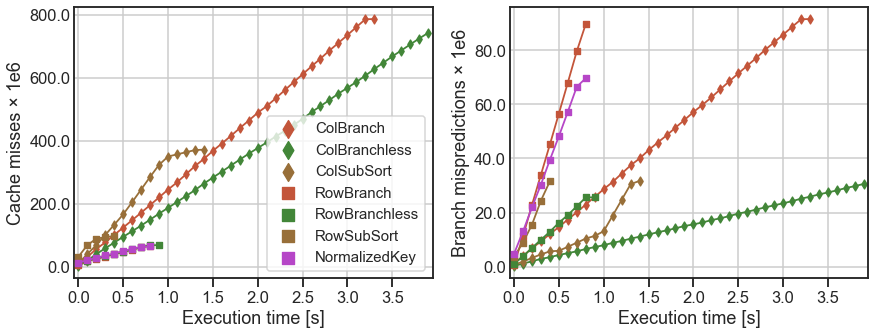

In [164]:
multi_trace([cm_comparator_df, bm_comparator_df],
            'trace_comparators', comp_cats, ['cm', 'bm'], h=5, asp=1.25, lg=0)

In [182]:
agg_ns = 10000000
cm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'cm', agg_ns)
bm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'bm', agg_ns)
con.execute("select max(counter) from cm_comparator_df where category = 'row_iter'")
con.fetchall()

rows: 1159
max time: 3920000000
rows: 1159
max time: 3920000000


[(97308148.0,)]

In [208]:
con.execute("""
with joined as (
    select cm.category, cm.time, cm.counter as cache_misses, bm.counter as branch_mispredictions
    from cm_comparator_df cm, bm_comparator_df bm
    where cm.category = bm.category
    and cm.time = bm.time
)
select
    category,
    max(time)::DOUBLE / 1000000000 as time_s,
    sum(cache_misses) / 1000000000 as cache_misses_billions,
    sum(branch_mispredictions) / 1000000000 as branch_mispredictions_billions
from joined
group by category
""")
res = con.fetchall()
# print(res)
transposed = []
for c in range(len(res[0])):
    new_row = []
    for r in range(len(res)):
        if type(res[r][c]) == float:
            new_row.append(f'{res[r][c]:.2f}')
        else:
            new_row.append(res[r][c])
    transposed.append(new_row)
# print(transposed)
print('\\toprule')
print(' & '.join(['Approach'] + comp_cats) + ' \\\\')
print('\\midrule')
print(' & '.join(['time'] + transposed[1]) + ' \\\\')
print(' & '.join(['cache misses'] + transposed[2]) + ' \\\\')
print(' & '.join(['branch mispredictions'] + transposed[3]) + ' \\\\')
print('\\bottomrule')

\toprule
Approach & ColBranch & ColBranchless & ColSubSort & RowBranch & RowBranchless & RowSubSort & NormalizedKey \\
\midrule
time & 3.27 & 3.92 & 1.36 & 0.81 & 0.88 & 0.46 & 0.82 \\
cache misses & 126.58 & 144.19 & 29.59 & 3.10 & 3.36 & 3.18 & 3.05 \\
branch mispredictions & 14.82 & 6.01 & 1.42 & 3.59 & 1.08 & 0.63 & 2.77 \\
\bottomrule


## Sort

In [74]:
agg_ns = 20000000
cm_sort_df = process_trace_csv(con, 'results/trace_sort.csv', 'cm', agg_ns)
bm_sort_df = process_trace_csv(con, 'results/trace_sort.csv', 'bm', agg_ns)

rows: 70
max time: 820000000
rows: 70
max time: 820000000


In [75]:
# plot_trace(cm_sort_df, 'cm', 'cm_sort', lg=True)

In [76]:
# plot_trace(bm_sort_df, 'bm', 'bm_sort', lg=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


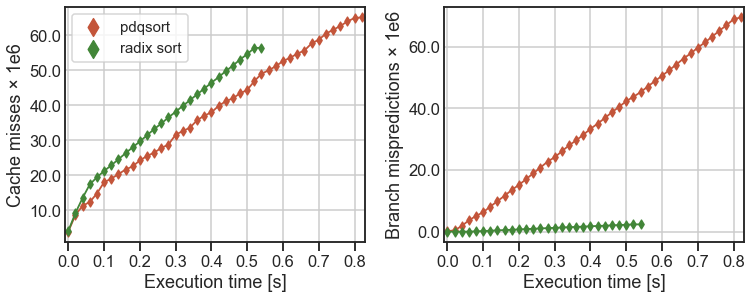

In [77]:
multi_trace([cm_sort_df, bm_sort_df],
            'trace_sort', ['pdqsort', 'radix sort'], ['cm', 'bm'], h=4.5, asp=1.2, lg=0)

## Key Merge

In [78]:
agg_ns = 20000000
cm_merge_key_df = process_trace_csv(con, 'results/trace_merge_key.csv', 'cm', agg_ns)
bm_merge_key_df = process_trace_csv(con, 'results/trace_merge_key.csv', 'bm', agg_ns)

rows: 47
max time: 300000000
rows: 47
max time: 300000000


In [79]:
# plot_trace(cm_merge_key_df, 'cm', 'cm_merge_key', h=4.5, asp=1.2, lg=True)

In [80]:
# plot_trace(bm_merge_key_df, 'bm', 'bm_merge_key', h=4.5, asp=1.2, lg=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


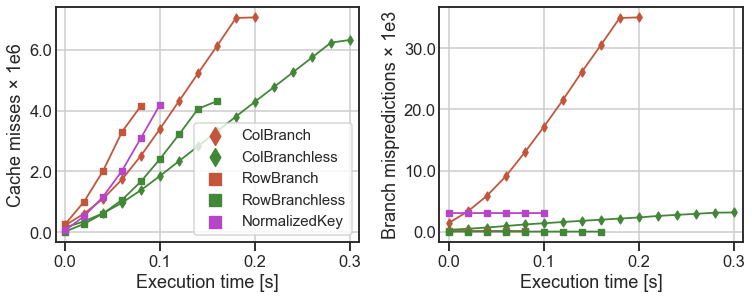

In [81]:
multi_trace([cm_merge_key_df, bm_merge_key_df],
            'trace_merge_key', ['ColBranch', 'ColBranchless', 'RowBranch', 'RowBranchless', 'NormalizedKey'],
            ['cm', 'bm'], h=4.5, asp=1.2, lg=0)

## Payload Merge

In [82]:
agg_ns = 20000000
cm_merge_payload_df = process_trace_csv(con, 'results/trace_merge_payload.csv', 'cm', agg_ns)
bm_merge_payload_df = process_trace_csv(con, 'results/trace_merge_payload.csv', 'bm', agg_ns)

rows: 70
max time: 860000000
rows: 70
max time: 860000000


In [83]:
# plot_trace(cm_merge_payload_df, 'cm', 'cm_merge_payload', lg=True)

In [84]:
# plot_trace(bm_merge_payload_df, 'bm', 'bm_merge_payload')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


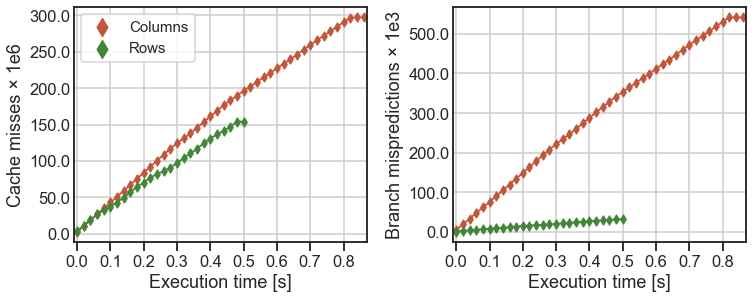

In [85]:
multi_trace([cm_merge_payload_df, bm_merge_payload_df],
            'trace_merge_payload', ['Columns', 'Rows'],
            ['cm', 'bm'], h=4.5, asp=1.2, lg=0)

# Templating ...

In [86]:
# for i in range(1, 257):
#     print(f'\tcase {i}:')
#     print(f'\t\treturn memcmp_fixed<{i}>(str1, str2);')

In [87]:
# for i in range(1, 257):
#     print(f'\tcase {i}:')
#     print(f'\t\treturn MemcpyFixed<{i}>(dest, src);')

In [88]:
# row = 'BranchedRowOrderEntry'
# row = 'BranchlessRowOrderEntry'
# row = 'NormalizedRowOrderEntry'
# print('switch (columns){')
# for i in range(1, 8):
#     print(f'case {i}:')
#     print(f'return MergeKeyRows<{row}{i}<T>>(left, right, count);')
# print('default:')
# print('assert(false);')
# print('}')